In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import torch
import matplotlib.pyplot as plt
import torchvision

import seaborn as sns


from torchvision.ops import batched_nms
import mmcv

from ensemble_boxes import *

from matplotlib.pyplot import imshow
from PIL import Image

In [48]:
def plot_image(img_path, boxes, labels):
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    image = image.astype('float32')
    
    categories = [
        { 'id':0, 'name': 'Aortic enlargement'},
        { 'id':1, 'name': 'Atelectasis'},
        { 'id':2, 'name': 'Calcification'},
        { 'id':3, 'name': 'Cardiomegaly'},
        { 'id':4, 'name': 'Consolidation'},
        { 'id':5, 'name': 'ILD'},
        { 'id':6, 'name': 'Infiltration'},
        { 'id':7, 'name': 'Lung Opacity'},
        { 'id':8, 'name': 'Nodule/Mass'},
        { 'id':9, 'name': 'Other lesion'},
        { 'id':10, 'name': 'Pleural effusion'},
        { 'id':11, 'name': 'Pleural thickening'},
        { 'id':12, 'name': 'Pneumothorax'},
        { 'id':13, 'name': 'Pulmonary fibrosis'},
        { 'id':14, 'name': 'No finding'},
    ] 
    
    plt.figure(figsize=(10,10))
    
    for box,label in zip(boxes, labels):
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (225,0,0), 4)
        label = categories[label]['name'].upper()
#         print(label)
        cv2.putText(image, 
                    label,
                    (box[0], box[1]), 
                    fontFace = cv2.FONT_HERSHEY_COMPLEX, 
                    fontScale = 1,
                    color = (255, 0, 0),
                    thickness = 2,
                    lineType = cv2.LINE_AA
                   )
    plt.imshow(image)

In [15]:
import pickle
from ensemble_boxes import *

with open('./test.pkl', 'rb') as f:
    data = pickle.load(f)
    
test_df = pd.read_csv('test.csv')

test_healthy = pd.read_csv('test_healthy.csv')
test_healthy = test_healthy.set_index('image_id')


submission_vals = []

min_score_thr = 0.1
# score_thr = {
#     0: 0.92,
#     1: 0.2,
#     2: 0.2,
#     3: 0.95,
#     4: 0.2,
#     5: 0.4,
#     6: 0.25,
#     7: 0.27,
#     8: 0.28,
#     9: 0.2,
#     10: 0.3,
#     11: 0.37,
#     12: 0.15,
#     13: 0.3,
# }

score_thr = {
    0: min_score_thr,
    1: min_score_thr,
    2: min_score_thr,
    3: min_score_thr,
    4: min_score_thr,
    5: min_score_thr,
    6: min_score_thr,
    7: min_score_thr,
    8: min_score_thr,
    9: min_score_thr,
    10: min_score_thr,
    11: min_score_thr,
    12: min_score_thr,
    13: min_score_thr,
}

iou_thr = 0.4

low_thr = 0.1
high_thr = 0.5

freq_df = []

box_counts = []

for _id, preds in zip(range(len(test_df)), data):
    
    r = test_df.iloc[_id]
    
    image_id = r['image_id']
    
    health_score = test_healthy.loc[image_id]['label']
    
    width = r['width']
    height = r['height']

    
    boxes = []
    scores = []
    labels = []
    
    for i, pred in enumerate(preds):
        if len(pred):
            for p in pred:
                
                score = p[4].astype(float)
                
                if score > score_thr[i]:

                    box = p[:4]
                    
#                     print(pred)
                    
                    box[0] = box[0] / (width)
                    box[2] = box[2] / (width)
                    box[1] = box[1] / (height)
                    box[3] = box[3] / (height)

                    boxes.append(box)
                    scores.append(score)
                    labels.append(i)
                    
                    freq_df.append(dict(
                        class_id=i,
                        image_id=image_id
                    ))
                    
    if len(boxes) == 0 or health_score < low_thr:
        pred_str = '14 1 0 0 1 1'
        submission_vals.append([image_id, pred_str])
        freq_df.append(dict(
                    class_id=14,
                    image_id=image_id
                ))
        continue 
    
    boxes, scores, labels = nms([boxes], [scores], [labels], iou_thr=iou_thr)
    
    boxes[:, 0] = boxes[:, 0]*width
    boxes[:, 2] = boxes[:, 2]*width
    boxes[:, 1] = boxes[:, 1]*height
    boxes[:, 3] = boxes[:, 3]*height
    
    scaled_boxes = boxes.astype(int)
    labels = labels.astype(int)
    _id_preds = []
    
    box_counts.append(len(scaled_boxes))
    
    for i in range(len(scaled_boxes)):
        _id_preds.append(str(labels[i]))
        _id_preds.append(str(scores[i].round(2)))
        _id_preds.append(str(scaled_boxes[i][0]))
        _id_preds.append(str(scaled_boxes[i][1]))
        _id_preds.append(str(scaled_boxes[i][2]))
        _id_preds.append(str(scaled_boxes[i][3]))

    pred_str = " ".join(_id_preds)
        
    if high_thr > health_score > low_thr:
        pred_str += f' 14 {1.0} 0 0 1 1'
    submission_vals.append([image_id, pred_str])
print(np.mean(box_counts))
df = pd.DataFrame(submission_vals, columns = ['image_id','PredictionString'])

8.161469933184856


In [16]:
len(df[df['PredictionString'] == '14 1 0 0 1 1'])

2102

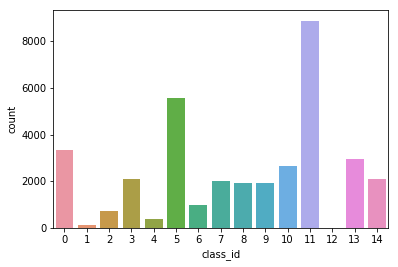

In [17]:
freq_df = pd.DataFrame(freq_df)

ax = sns.countplot(x="class_id",data=freq_df)

In [18]:
df.to_csv("submission.csv",index=False)

# Train Data

In [82]:
# 0 - Aortic enlargement
# 1 - Atelectasis
# 2 - Calcification
# 3 - Cardiomegaly
# 4 - Consolidation
# 5 - ILD
# 6 - Infiltration
# 7 - Lung Opacity
# 8 - Nodule/Mass
# 9 - Other lesion
# 10 - Pleural effusion
# 11 - Pleural thickening
# 12 - Pneumothorax
# 13 - Pulmonary fibrosis

# df = pd.read_csv('5_fold_dedub_abnormal_org_size.csv')
df = pd.read_csv('train.csv')
# print(len(dub_df[dub_df.class_id != 14]))
# clear = dub_df[dub_df.class_id == 14].groupby(['image_id', 'class_name']).mean().reset_index()
# abnormal = pd.read_csv('abnormal_dedub_org_size.csv')
# print(len(abnormal))
# dub_df = pd.concat([clear, abnormal])
# dub_df.class_id.hist()

# df_minority = df.groupby('class_id').filter(lambda x: len(x) < 112).reset_index()
df_minority = df[df.class_id == 8]

# ax = sns.countplot(x="class_id",data=df_minority)

# df.class_id.value_counts()
df_minority.class_id.value_counts()

8    2580
Name: class_id, dtype: int64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


127f66766091998a72268caf4ec34bef


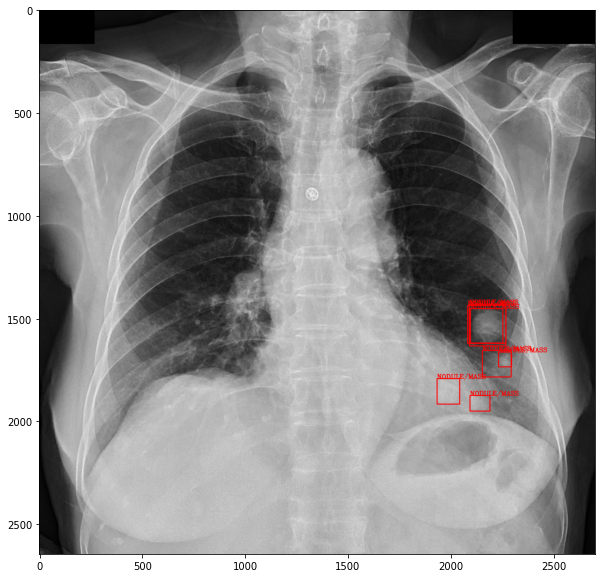

In [89]:
df = df_minority.groupby('image_id').agg(lambda x: list(x)).reset_index()
idx = 60
records = df.loc[idx]
image_id = records['image_id']

print(image_id)
# width = meta.loc[image_id]['dim1']
# height = meta.loc[image_id]['dim0']

labels = records['class_id']
scores = np.ones(len(labels))

boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
boxes = np.array(boxes.tolist()).T
boxes = boxes.astype(int)

img_path = 'vinbigdata/images/train/' + image_id + '.jpg'

# 19da7247b897983617e17c69636620ad - one large module mass

plot_image(img_path, boxes, labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


da35978a37f990de5a0d68b1e9399e9e
AORTIC ENLARGEMENT 0.725
CARDIOMEGALY 0.651
[[1550  962 1877 1385]
 [1247 1719 2282 2180]]


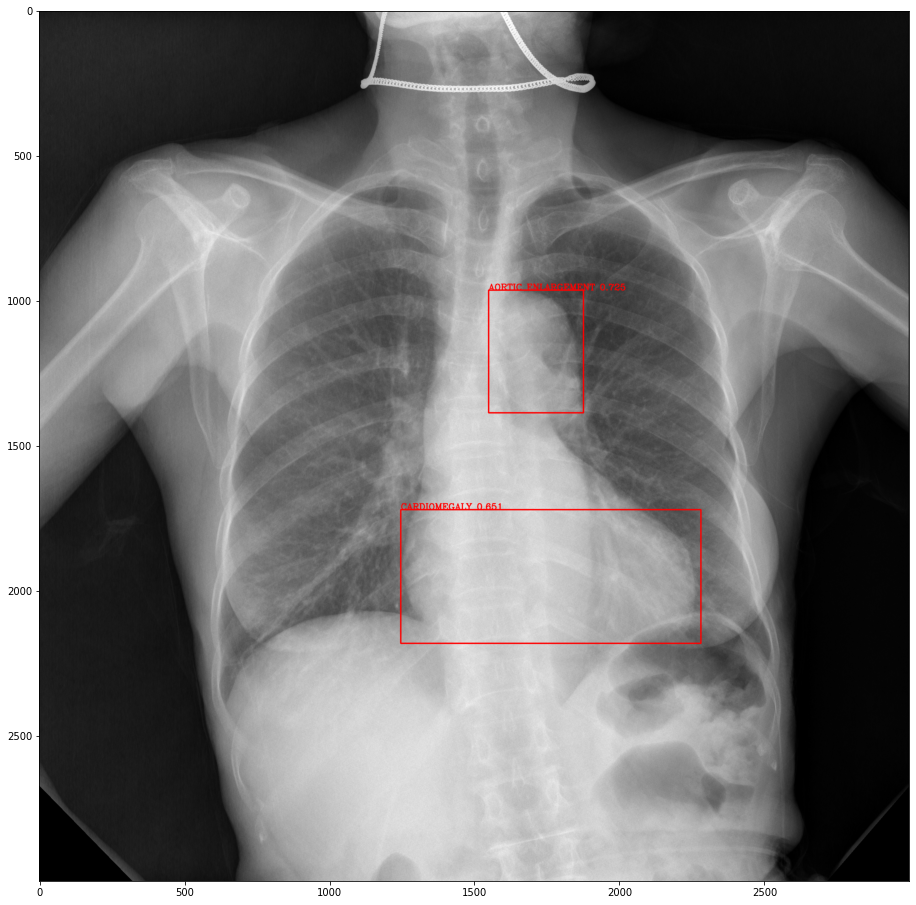

In [40]:
sub = pd.read_csv('submission.csv')

row = sub.iloc[24 - 1]
pred_string = row['PredictionString']
image_id = row['image_id']
print(image_id)
img_path = 'vinbigdata/images/test/' + image_id + '.jpg'

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255
image = image.astype('float32')

# boxes = np.array(boxes)
# boxes
pred = np.array(list(map(lambda x: float(x), pred_string.split(' '))))
pred = pred.reshape(-1,6)

boxes = pred[:, 2:].astype(int) 
scores = pred[:,1].astype(float)
labels = pred[:,0].astype(int)

boxes = boxes[scores > 0.5]
labels = labels[scores > 0.5]
scores = scores[scores > 0.5]


plot_image(image, boxes, labels, scores)
# boxes, labels
print(boxes[scores > 0.01])